# Style Transfer
In this notebook we will implement the style transfer technique from ["Image Style Transfer Using Convolutional Neural Networks" (Gatys et al., CVPR 2015)](http://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf).

The general idea is to take two images, and produce a new image that reflects the content of one but the artistic "style" of the other. We will do this by first formulating a loss function that matches the content and style of each respective image in the feature space of a deep network, and then performing gradient descent on the pixels of the image itself.

The deep network we use as a feature extractor is [SqueezeNet](https://arxiv.org/abs/1602.07360), a small model that has been trained on ImageNet. You could use any network, but we chose SqueezeNet here for its small size and efficiency.

Here's an example of the images you'll be able to produce by the end of this notebook:

![caption](example_styletransfer.png)



## Setup

In [1]:

%load_ext autoreload
%autoreload 2
from scipy.misc import imread, imresize
import numpy as np

from scipy.misc import imread
import matplotlib.pyplot as plt

# Helper functions to deal with image preprocessing
from cs231n.image_utils import load_image, preprocess_image, deprocess_image

%matplotlib inline

def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# Older versions of scipy.misc.imresize yield different results
# from newer versions, so we check to make sure scipy is up to date.
def check_scipy():
    import scipy
    version = scipy.__version__.split('.')
    if int(version[0]) < 1:
        assert int(version[1]) >= 16, "You must install SciPy >= 0.16.0 to complete this notebook."

check_scipy()

Load the pretrained SqueezeNet model. This model has been ported from PyTorch, see `cs231n/classifiers/squeezenet.py` for the model architecture. 

To use SqueezeNet, you will need to first **download the weights** by descending into the `cs231n/datasets` directory and running `get_squeezenet_tf.sh` . Note that if you ran `get_assignment3_data.sh` then SqueezeNet will already be downloaded.

In [2]:
from cs231n.classifiers.squeezenet import SqueezeNet
import tensorflow as tf
import os

tf.reset_default_graph() # remove all existing variables in the graph 
sess = get_session() # start a new Session

# Load pretrained SqueezeNet model
SAVE_PATH = 'cs231n/datasets/squeezenet.ckpt'
if not os.path.exists(SAVE_PATH + ".index"):
    raise ValueError("You need to download SqueezeNet!")
model = SqueezeNet(save_path=SAVE_PATH, sess=sess)

# Load data for testing
content_img_test = preprocess_image(load_image('styles/tubingen.jpg', size=192))[None]
style_img_test = preprocess_image(load_image('styles/starry_night.jpg', size=192))[None]
answers = np.load('style-transfer-checks-tf.npz')


INFO:tensorflow:Restoring parameters from cs231n/datasets/squeezenet.ckpt


## Computing Loss

We're going to compute the three components of our loss function now. The loss function is a weighted sum of three terms: content loss + style loss + total variation loss. You'll fill in the functions that compute these weighted terms below.

## Content loss
We can generate an image that reflects the content of one image and the style of another by incorporating both in our loss function. We want to penalize deviations from the content of the content image and deviations from the style of the style image. We can then use this hybrid loss function to perform gradient descent **not on the parameters** of the model, but instead **on the pixel values** of our original image.

Let's first write the content loss function. Content loss measures how much the feature map of the generated image differs from the feature map of the source image. We only care about the content representation of one layer of the network (say, layer $\ell$), that has feature maps $A^\ell \in \mathbb{R}^{1 \times H_\ell \times W_\ell \times C_\ell}$. $C_\ell$ is the number of filters/channels in layer $\ell$, $H_\ell$ and $W_\ell$ are the height and width. We will work with reshaped versions of these feature maps that combine all spatial positions into one dimension. Let $F^\ell \in \mathbb{R}^{M_\ell \times C_\ell}$ be the feature map for the current image and $P^\ell \in \mathbb{R}^{M_\ell \times C_\ell}$ be the feature map for the content source image where $M_\ell=H_\ell\times W_\ell$ is the number of elements in each feature map. Each row of $F^\ell$ or $P^\ell$ represents the vectorized activations of a particular filter, convolved over all positions of the image. Finally, let $w_c$ be the weight of the content loss term in the loss function.

Then the content loss is given by:

$L_c = w_c \times \sum_{i,j} (F_{ij}^{\ell} - P_{ij}^{\ell})^2$

In [3]:
def content_loss(content_weight, content_current, content_original):
    """
    Compute the content loss for style transfer.
    
    Inputs:
    - content_weight: scalar constant we multiply the content_loss by.
    - content_current: features of the current image, Tensor with shape [1, height, width, channels]
    - content_target: features of the content image, Tensor with shape [1, height, width, channels]
    
    Returns:
    - scalar content loss
    """
    _, H, W, C = content_current.shape
    current_map = tf.reshape(content_current, [-1, C])
    target_map = tf.reshape(content_original, [-1, C])
    content_loss = tf.reduce_sum(tf.square(current_map - target_map)) * content_weight
    return content_loss

Test your content loss. You should see errors less than 0.0001.

In [4]:
def content_loss_test(correct):
    content_layer = 3
    content_weight = 6e-2
    c_feats = sess.run(model.extract_features()[content_layer], {model.image: content_img_test})
    bad_img = tf.zeros(content_img_test.shape)
    feats = model.extract_features(bad_img)[content_layer]
    student_output = sess.run(content_loss(content_weight, c_feats, feats))
    error = rel_error(correct, student_output)
    print('Maximum error is {:.3f}'.format(error))

content_loss_test(answers['cl_out'])

Maximum error is 0.000


## Style loss
Now we can tackle the style loss. For a given layer $\ell$, the style loss is defined as follows:

First, compute the Gram matrix G which represents the correlations between the responses of each filter, where F is as above. The Gram matrix is an approximation to the covariance matrix -- we want the activation statistics of our generated image to match the activation statistics of our style image, and matching the (approximate) covariance is one way to do that. There are a variety of ways you could do this, but the Gram matrix is nice because it's easy to compute and in practice shows good results.

Given a feature map $F^\ell$ of shape $(M_\ell, C_\ell)$, the Gram matrix has shape $(C_\ell, C_\ell)$ and its elements are given by:

$$G_{ij}^\ell  = \sum_k F^{\ell}_{ki} F^{\ell}_{kj}$$

Assuming $G^\ell$ is the Gram matrix from the feature map of the current image, $A^\ell$ is the Gram Matrix from the feature map of the source style image, and $w_\ell$ a scalar weight term, then the style loss for the layer $\ell$ is simply the weighted Euclidean distance between the two Gram matrices:

$$L_s^\ell = w_\ell \sum_{i, j} \left(G^\ell_{ij} - A^\ell_{ij}\right)^2$$

In practice we usually compute the style loss at a set of layers $\mathcal{L}$ rather than just a single layer $\ell$; then the total style loss is the sum of style losses at each layer:

$$L_s = \sum_{\ell \in \mathcal{L}} L_s^\ell$$

Begin by implementing the Gram matrix computation below:

In [5]:
def gram_matrix(features, normalize=True):
    """
    Compute the Gram matrix from features.
    
    Inputs:
    - features: Tensor of shape (1, H, W, C) giving features for
      a single image.
    - normalize: optional, whether to normalize the Gram matrix
        If True, divide the Gram matrix by the number of neurons (H * W * C)
    
    Returns:
    - gram: Tensor of shape (C, C) giving the (optionally normalized)
      Gram matrices for the input image.
    """
    _, H, W, C = features.shape
    features_vec = tf.reshape(features, [-1, C])
    gram = tf.matmul(tf.transpose(features_vec), features_vec)
    if normalize:
        n = tf.to_float(tf.reduce_prod(tf.shape(features)))
        gram = tf.divide(gram, n)
    return gram


Test your Gram matrix code. You should see errors less than 0.0001.

In [6]:
def gram_matrix_test(correct):
    gram = gram_matrix(model.extract_features()[5])
    student_output = sess.run(gram, {model.image: style_img_test})
    error = rel_error(correct, student_output)
    print('Maximum error is {:.3f}'.format(error))

gram_matrix_test(answers['gm_out'])

Maximum error is 0.000


Next, implement the style loss:

In [7]:
def style_loss(feats, style_layers, style_targets, style_weights):
    """
    Computes the style loss at a set of layers.
    
    Inputs:
    - feats: list of the features at every layer of the current image, as produced by
      the extract_features function.
    - style_layers: List of layer indices into feats giving the layers to include in the
      style loss.
    - style_targets: List of the same length as style_layers, where style_targets[i] is
      a Tensor giving the Gram matrix of the source style image computed at
      layer style_layers[i].
    - style_weights: List of the same length as style_layers, where style_weights[i]
      is a scalar giving the weight for the style loss at layer style_layers[i].
      
    Returns:
    - style_loss: A Tensor containing the scalar style loss.
    """
    # Hint: you can do this with one for loop over the style layers, and should
    # not be very much code (~5 lines). You will need to use your gram_matrix function.
    loss = 0
    for i, layer in enumerate(style_layers):
        cur_gram = gram_matrix(feats[layer])
        tar_gram = style_targets[i]
        loss += tf.reduce_sum(tf.square(cur_gram - tar_gram)) * style_weights[i]
    return loss


Test your style loss implementation. The error should be less than 0.0001.

In [8]:
def style_loss_test(correct):
    style_layers = [1, 4, 6, 7]
    style_weights = [300000, 1000, 15, 3]
    
    feats = model.extract_features()
    style_target_vars = []
    for idx in style_layers:
        style_target_vars.append(gram_matrix(feats[idx]))
    style_targets = sess.run(style_target_vars,
                             {model.image: style_img_test})
                             
    s_loss = style_loss(feats, style_layers, style_targets, style_weights)
    student_output = sess.run(s_loss, {model.image: content_img_test})
    error = rel_error(correct, student_output)
    print('Error is {:.3f}'.format(error))

style_loss_test(answers['sl_out'])

Error is 0.000


## Total-variation regularization
It turns out that it's helpful to also encourage smoothness in the image. We can do this by adding another term to our loss that penalizes wiggles or "total variation" in the pixel values. 

You can compute the "total variation" as the sum of the squares of differences in the pixel values for all pairs of pixels that are next to each other (horizontally or vertically). Here we sum the total-variation regualarization for each of the 3 input channels (RGB), and weight the total summed loss by the total variation weight, $w_t$:

$L_{tv} = w_t \times \left(\sum_{c=1}^3\sum_{i=1}^{H-1}\sum_{j=1}^{W} (x_{i+1,j,c} - x_{i,j,c})^2 + \sum_{c=1}^3\sum_{i=1}^{H}\sum_{j=1}^{W - 1} (x_{i,j+1,c} - x_{i,j,c})^2\right)$

In the next cell, fill in the definition for the TV loss term. To receive full credit, your implementation should not have any loops.

In [9]:
def tv_loss(img, tv_weight):
    """
    Compute total variation loss.
    
    Inputs:
    - img: Tensor of shape (1, H, W, 3) holding an input image.
    - tv_weight: Scalar giving the weight w_t to use for the TV loss.
    
    Returns:
    - loss: Tensor holding a scalar giving the total variation loss
      for img weighted by tv_weight.
    """
    # Your implementation should be vectorized and not require any loops!
    shape = tf.shape(img)
    H = tf.gather(shape, 1)
    W = tf.gather(shape, 2)
    crop_h = tf.image.crop_to_bounding_box(img, 0, 0, H-1, W)
    crop_h_shift = tf.image.crop_to_bounding_box(img, 1, 0, H-1, W)
    crop_w = tf.image.crop_to_bounding_box(img, 0, 0, H, W-1)
    crop_w_shift = tf.image.crop_to_bounding_box(img, 0, 1, H, W-1)
    loss = tf.reduce_sum(tf.square(crop_h_shift - crop_h)) + tf.reduce_sum(tf.square(crop_w_shift - crop_w))
    return loss * tv_weight

Test your TV loss implementation. Error should be less  than 0.0001.

In [10]:
def tv_loss_test(correct):
    tv_weight = 2e-2
    t_loss = tv_loss(model.image, tv_weight)
    student_output = sess.run(t_loss, {model.image: content_img_test})
    error = rel_error(correct, student_output)
    print('Error is {:.3f}'.format(error))

tv_loss_test(answers['tv_out'])

Error is 0.000


## Style Transfer

Lets put it all together and make some beautiful images! The `style_transfer` function below combines all the losses you coded up above and optimizes for an image that minimizes the total loss.

In [11]:
def style_transfer(content_image, style_image, image_size, style_size, content_layer, content_weight,
                   style_layers, style_weights, tv_weight, init_random = False):
    """Run style transfer!
    
    Inputs:
    - content_image: filename of content image
    - style_image: filename of style image
    - image_size: size of smallest image dimension (used for content loss and generated image)
    - style_size: size of smallest style image dimension
    - content_layer: layer to use for content loss
    - content_weight: weighting on content loss
    - style_layers: list of layers to use for style loss
    - style_weights: list of weights to use for each layer in style_layers
    - tv_weight: weight of total variation regularization term
    - init_random: initialize the starting image to uniform random noise
    """
    # Extract features from the content image
    content_img = preprocess_image(load_image(content_image, size=image_size))
    feats = model.extract_features(model.image)
    content_target = sess.run(feats[content_layer],
                              {model.image: content_img[None]})

    # Extract features from the style image
    style_img = preprocess_image(load_image(style_image, size=style_size))
    style_feat_vars = [feats[idx] for idx in style_layers]
    style_target_vars = []
    # Compute list of TensorFlow Gram matrices
    for style_feat_var in style_feat_vars:
        style_target_vars.append(gram_matrix(style_feat_var))
    # Compute list of NumPy Gram matrices by evaluating the TensorFlow graph on the style image
    style_targets = sess.run(style_target_vars, {model.image: style_img[None]})

    # Initialize generated image to content image
    
    if init_random:
        img_var = tf.Variable(tf.random_uniform(content_img[None].shape, 0, 1), name="image")
    else:
        img_var = tf.Variable(content_img[None], name="image")

    # Extract features on generated image
    feats = model.extract_features(img_var)
    # Compute loss
    c_loss = content_loss(content_weight, feats[content_layer], content_target)
    s_loss = style_loss(feats, style_layers, style_targets, style_weights)
    t_loss = tv_loss(img_var, tv_weight)
    loss = c_loss + s_loss + t_loss
    
    # Set up optimization hyperparameters
    initial_lr = 3.0
    decayed_lr = 0.1
    decay_lr_at = 180
    max_iter = 200

    # Create and initialize the Adam optimizer
    lr_var = tf.Variable(initial_lr, name="lr")
    # Create train_op that updates the generated image when run
    with tf.variable_scope("optimizer") as opt_scope:
        train_op = tf.train.AdamOptimizer(lr_var).minimize(loss, var_list=[img_var])
    # Initialize the generated image and optimization variables
    opt_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=opt_scope.name)
    sess.run(tf.variables_initializer([lr_var, img_var] + opt_vars))
    # Create an op that will clamp the image values when run
    clamp_image_op = tf.assign(img_var, tf.clip_by_value(img_var, -1.5, 1.5))
    
    f, axarr = plt.subplots(1,2)
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[0].set_title('Content Source Img.')
    axarr[1].set_title('Style Source Img.')
    axarr[0].imshow(deprocess_image(content_img))
    axarr[1].imshow(deprocess_image(style_img))
    plt.show()
    plt.figure()
    
    # Hardcoded handcrafted 
    for t in range(max_iter):
        # Take an optimization step to update img_var
        sess.run(train_op)
        if t < decay_lr_at:
            sess.run(clamp_image_op)
        if t == decay_lr_at:
            sess.run(tf.assign(lr_var, decayed_lr))
        if t % 100 == 0:
            print('Iteration {}'.format(t))
            img = sess.run(img_var)
            plt.imshow(deprocess_image(img[0], rescale=True))
            plt.axis('off')
            plt.show()
    print('Iteration {}'.format(t))
    img = sess.run(img_var)        
    plt.imshow(deprocess_image(img[0], rescale=True))
    plt.axis('off')
    plt.show()

## Generate some pretty pictures!

Try out `style_transfer` on the three different parameter sets below. Make sure to run all three cells. Feel free to add your own, but make sure to include the results of style transfer on the third parameter set (starry night) in your submitted notebook.

* The `content_image` is the filename of content image.
* The `style_image` is the filename of style image.
* The `image_size` is the size of smallest image dimension of the content image (used for content loss and generated image).
* The `style_size` is the size of smallest style image dimension.
* The `content_layer` specifies which layer to use for content loss.
* The `content_weight` gives weighting on content loss in the overall loss function. Increasing the value of this parameter will make the final image look more realistic (closer to the original content).
* `style_layers` specifies a list of which layers to use for style loss. 
* `style_weights` specifies a list of weights to use for each layer in style_layers (each of which will contribute a term to the overall style loss). We generally use higher weights for the earlier style layers because they describe more local/smaller scale features, which are more important to texture than features over larger receptive fields. In general, increasing these weights will make the resulting image look less like the original content and more distorted towards the appearance of the style image.
* `tv_weight` specifies the weighting of total variation regularization in the overall loss function. Increasing this value makes the resulting image look smoother and less jagged, at the cost of lower fidelity to style and content. 

Below the next three cells of code (in which you shouldn't change the hyperparameters), feel free to copy and paste the parameters to play around them and see how the resulting image changes. 

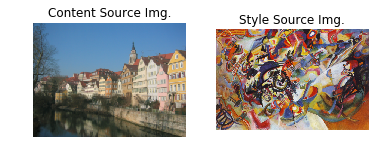

Iteration 0


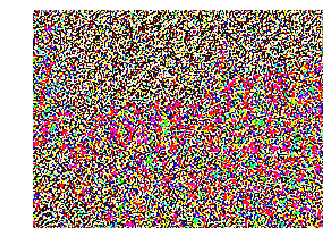

Iteration 100


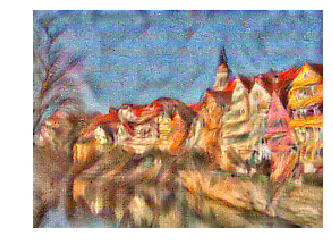

Iteration 199


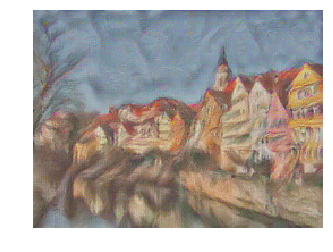

In [12]:
# Composition VII + Tubingen
params1 = {
    'content_image' : 'styles/tubingen.jpg',
    'style_image' : 'styles/composition_vii.jpg',
    'image_size' : 192,
    'style_size' : 512,
    'content_layer' : 3,
    'content_weight' : 5e-2, 
    'style_layers' : (1, 4, 6, 7),
    'style_weights' : (20000, 500, 12, 1),
    'tv_weight' : 5e-2
}

style_transfer(**params1)

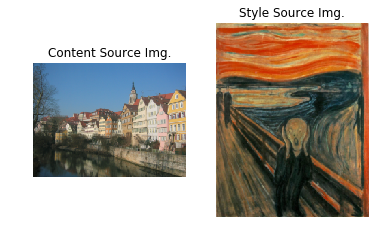

Iteration 0


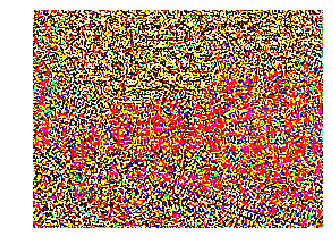

Iteration 100


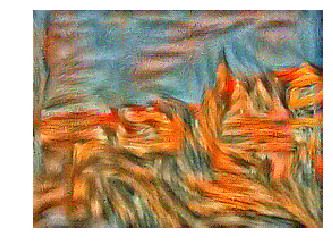

Iteration 199


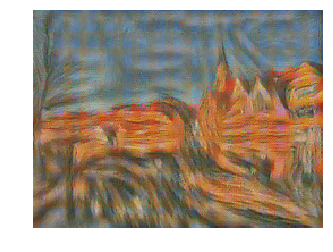

In [13]:
# Scream + Tubingen
params2 = {
    'content_image':'styles/tubingen.jpg',
    'style_image':'styles/the_scream.jpg',
    'image_size':192,
    'style_size':224,
    'content_layer':3,
    'content_weight':3e-2,
    'style_layers':[1, 4, 6, 7],
    'style_weights':[200000, 800, 12, 1],
    'tv_weight':2e-2
}

style_transfer(**params2)

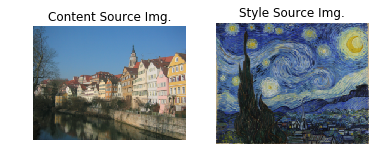

Iteration 0


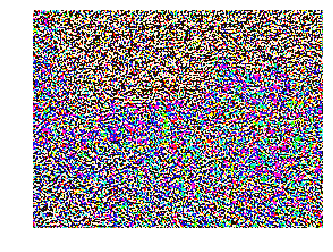

Iteration 100


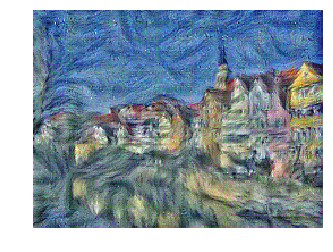

Iteration 199


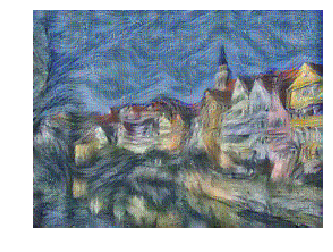

In [14]:
# Starry Night + Tubingen
params3 = {
    'content_image' : 'styles/tubingen.jpg',
    'style_image' : 'styles/starry_night.jpg',
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 3,
    'content_weight' : 6e-2,
    'style_layers' : [1, 4, 6, 7],
    'style_weights' : [300000, 1000, 15, 3],
    'tv_weight' : 2e-2
}

style_transfer(**params3)

## Feature Inversion

The code you've written can do another cool thing. In an attempt to understand the types of features that convolutional networks learn to recognize, a recent paper [1] attempts to reconstruct an image from its feature representation. We can easily implement this idea using image gradients from the pretrained network, which is exactly what we did above (but with two different feature representations).

Now, if you set the style weights to all be 0 and initialize the starting image to random noise instead of the content source image, you'll reconstruct an image from the feature representation of the content source image. You're starting with total noise, but you should end up with something that looks quite a bit like your original image.

(Similarly, you could do "texture synthesis" from scratch if you set the content weight to 0 and initialize the starting image to random noise, but we won't ask you to do that here.) 

Run the following cell to try out feature inversion.

[1] Aravindh Mahendran, Andrea Vedaldi, "Understanding Deep Image Representations by Inverting them", CVPR 2015


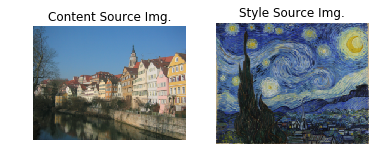

Iteration 0


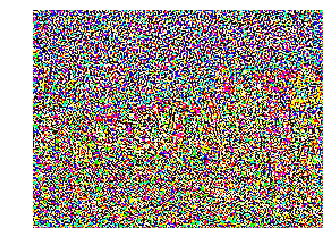

Iteration 100


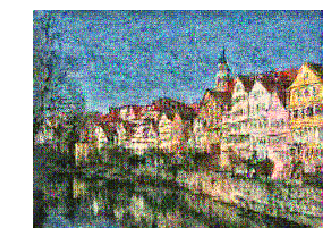

Iteration 199


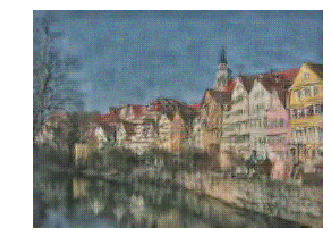

In [15]:
# Feature Inversion -- Starry Night + Tubingen
params_inv = {
    'content_image' : 'styles/tubingen.jpg',
    'style_image' : 'styles/starry_night.jpg',
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 3,
    'content_weight' : 6e-2,
    'style_layers' : [1, 4, 6, 7],
    'style_weights' : [0, 0, 0, 0], # we discard any contributions from style to the loss
    'tv_weight' : 2e-2,
    'init_random': True # we want to initialize our image to be random
}

style_transfer(**params_inv)